# Vincent Purcell
##### Data Mining 2 - Final Project #####

### Set up MongoDB Connections ###

In [1]:
import pymongo

# MongoDB Connections
client = pymongo.MongoClient('mongodb://localhost:27017')
db = client['MLB_DB']
gameSummaryDB = db['GameSummary']
gamePlayerDataDB = db['GamePlayerData']
playerProjectionsDB = db['PlayerProjectedStats']

In [2]:
def getStatAvg(stats_list, projections_str, player_projected_stats_doc):
    stat_averages = [0] * len(stats_list)
    count = 0
    for player in player_projected_stats_doc[projections_str].values():
        stat_index = 0
        for stat in stats_list:
            try:
                stat_val = float(player[stat])
            except:
                stat_val = 0
            stat_averages[stat_index] = stat_averages[stat_index] + stat_val
            stat_index = stat_index + 1
        count = count + 1
    stat_averages = [i/count for i in stat_averages]
    return stat_averages

In [3]:
import datahelp

columns = datahelp.columns
data = []
for document in gameSummaryDB.find():
    game_id = document['game_id_num']
    for player_data in gamePlayerDataDB.find({'game_id_num': str(game_id)}):
        home_umpire = [player_data['umpires']['home']['id']]
    for player_projections in playerProjectionsDB.find({'game_id_num': str(game_id)}):
        # Get Stat averages
        home_batting_avg = getStatAvg(datahelp.batting_stats, 'home_batting_projections', player_projections)
        away_batting_avg = getStatAvg(datahelp.batting_stats, 'away_batting_projections', player_projections)
        home_pitching = getStatAvg(datahelp.pitching_stats, 'home_pitcher_projections', player_projections)
        away_pitching = getStatAvg(datahelp.pitching_stats, 'away_pitcher_projections', player_projections)
    home_win = [1 if document['home_score']>document['away_score'] else 0]
    data_row = home_batting_avg + away_batting_avg + home_pitching + away_pitching + home_umpire + home_win
    data.append(data_row)

In [4]:
import numpy as np
import pandas as pd

data_df = pd.DataFrame(np.array(data), columns=columns)
print("Data count (rows, columns) : " + str(data_df.shape))
data_df.head()

Data count (rows, columns) : (1202, 34)


,home hr avg,home sac avg,home rbi avg,home tb avg,home slg avg,home avg avg,home so avg,home tpa avg,home obp avg,away hr avg,...,home pitching pa,away pitching hr,away pitching wpct,away pitching era,away pitching outs,away pitching h,away pitching ip,away pitching pa,umpire_id,home win
0,15.222222,4.000000,80.666667,283.111111,0.393667,0.259111,160.888889,800.333333,0.321556,29.000000,...,398.0,14.0,0.667,3.67,427.0,158.0,142.1,617.0,484499.0,0.0
1,16.777778,3.888889,77.444444,273.888889,0.384889,0.250778,158.555556,768.888889,0.316111,30.222222,...,1065.0,9.0,0.167,5.46,173.0,70.0,57.2,265.0,482666.0,0.0
2,16.333333,2.777778,63.222222,214.555556,0.377667,0.230000,130.444444,586.777778,0.295556,25.666667,...,796.0,35.0,0.318,6.10,575.0,226.0,191.2,869.0,427315.0,0.0
3,18.555556,3.222222,78.222222,265.444444,0.406556,0.254111,158.555556,720.000000,0.316111,23.555556,...,1486.0,46.0,0.478,3.89,1166.0,371.0,388.2,1654.0,428442.0,1.0
4,17.555556,3.222222,81.444444,280.888889,0.409444,0.262444,150.222222,752.888889,0.319111,27.111111,...,398.0,30.0,0.429,4.86,766.0,264.0,255.1,1143.0,427044.0,1.0


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


1.0    456
0.0    385
Name: home win, dtype: int64

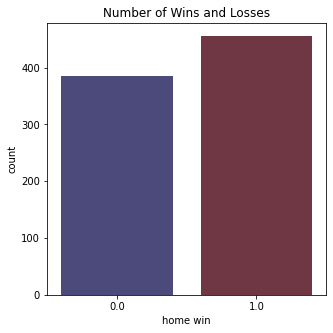

In [15]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

X = data_df.drop(['home win'], axis = 1)
y = data_df['home win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)
# visualize number of digits classes
plt.figure(figsize=(5,5))
g = sns.countplot(y_train, palette="icefire")
plt.title("Number of Wins and Losses")
y_train.value_counts()

<AxesSubplot:>

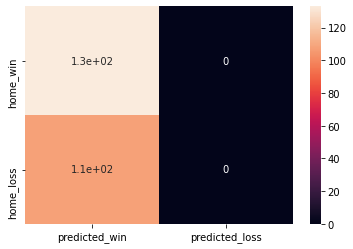

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

mlp = MLPClassifier(hidden_layer_sizes=(50,75,98), max_iter=2000)
mlp.fit(X_train,y_train)
y_predict = mlp.predict(X_test)

cm = np.array(confusion_matrix(y_test, y_predict, labels=[1,0]))
confusion = pd.DataFrame(cm, index=['home_win', 'home_loss'],
                         columns=['predicted_win','predicted_loss'])
sns.heatmap(confusion, annot=True)

<AxesSubplot:>

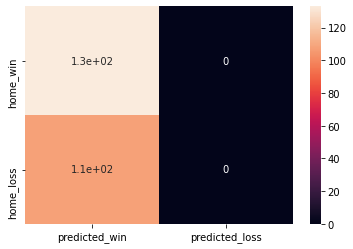

In [8]:
from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(X_train, y_train)
y_predict = svc_model.predict(X_test)

cm = np.array(confusion_matrix(y_test, y_predict, labels=[1,0]))
confusion = pd.DataFrame(cm, index=['home_win', 'home_loss'],
                         columns=['predicted_win','predicted_loss'])
sns.heatmap(confusion, annot=True)

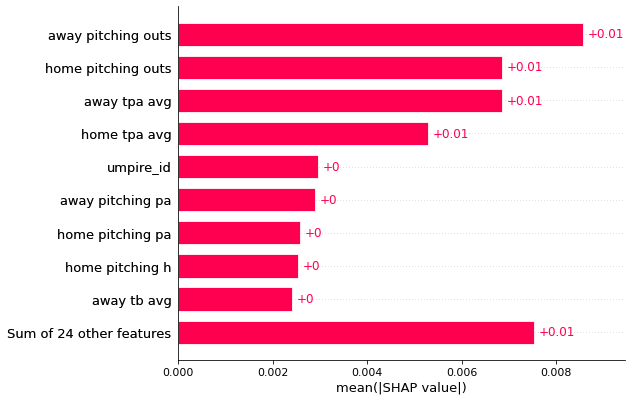

In [9]:
import shap
from sklearn.svm import SVR
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
svr_poly.fit(X_train, y_train)
y_predict = svr_poly.predict(X_test)
explainer = shap.explainers.Permutation(svr_poly.predict, X_test)
shap_values_svc = explainer(X_test[:100], silent=True)
shap.plots.bar(shap_values_svc)

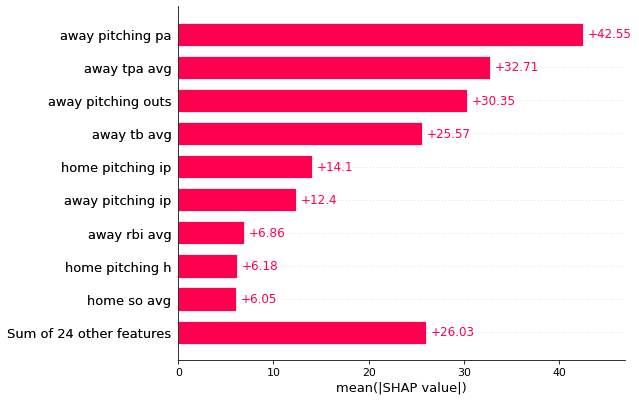

In [10]:
from sklearn.neural_network import MLPRegressor
mlp_regr = MLPRegressor(random_state=1, max_iter=2000).fit(X_train, y_train)
y_predict = mlp_regr.predict(X_test)
explainer = shap.explainers.Permutation(mlp_regr.predict, X_test)
shap_values_svc = explainer(X_test[:100], silent=True)
shap.plots.bar(shap_values_svc)

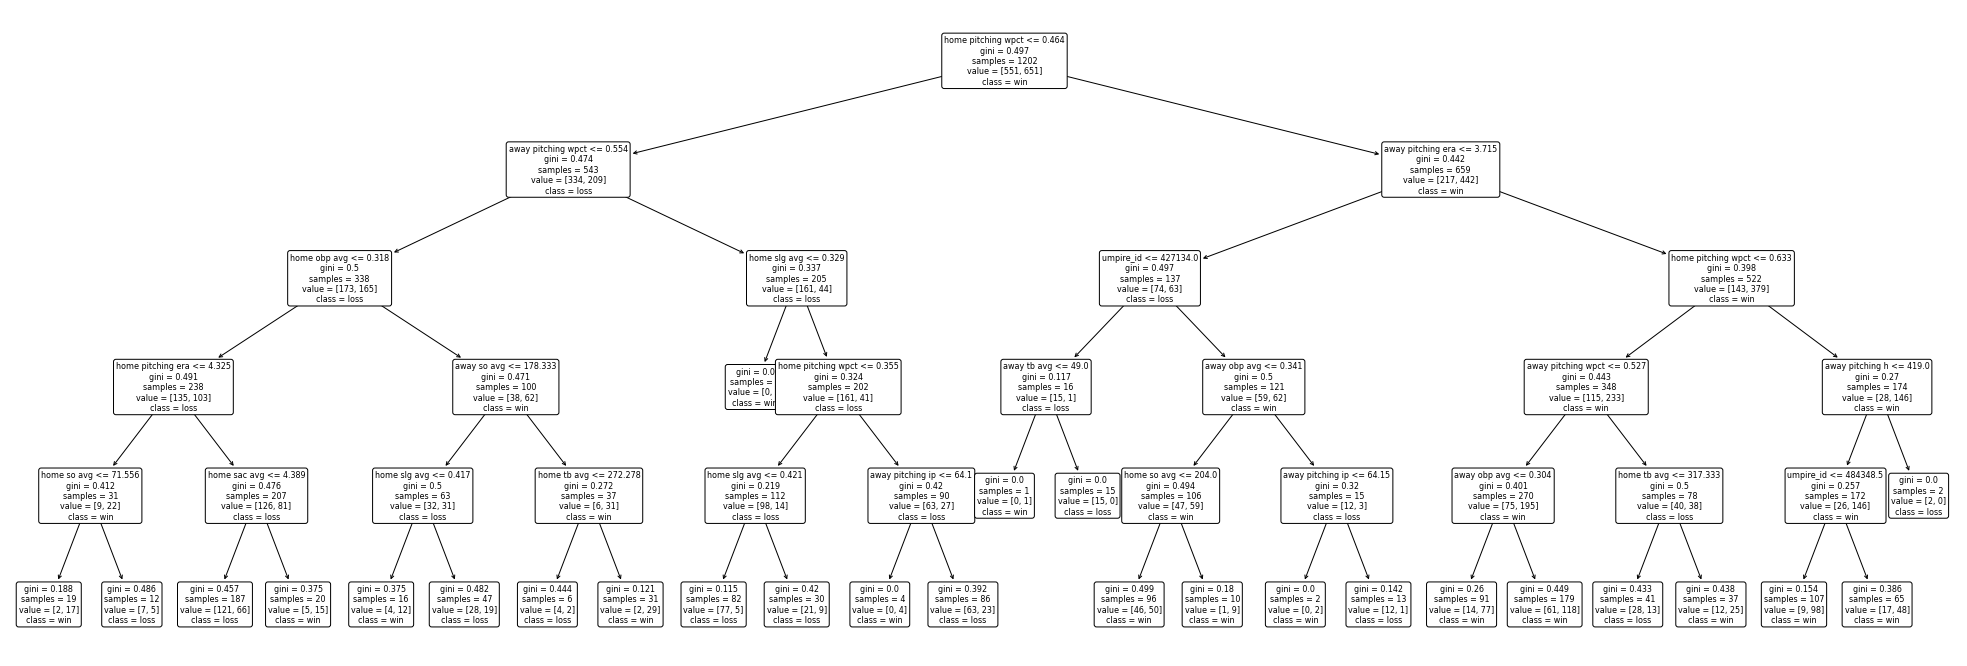

In [30]:
from sklearn import tree

clf_dt = tree.DecisionTreeClassifier(max_depth=5)
clf_dt = clf_dt.fit(X, y)
plt.figure(figsize=(35,12))
tree.plot_tree(clf_dt,feature_names=columns,class_names=['loss','win'],rounded=True,fontsize=8);
plt.show()
predictions_dt = clf_dt.predict(X_test)

Decision Tree Classification
Number of mislabeled points out of a total 361 points: 0
Accuracy: 1.000000


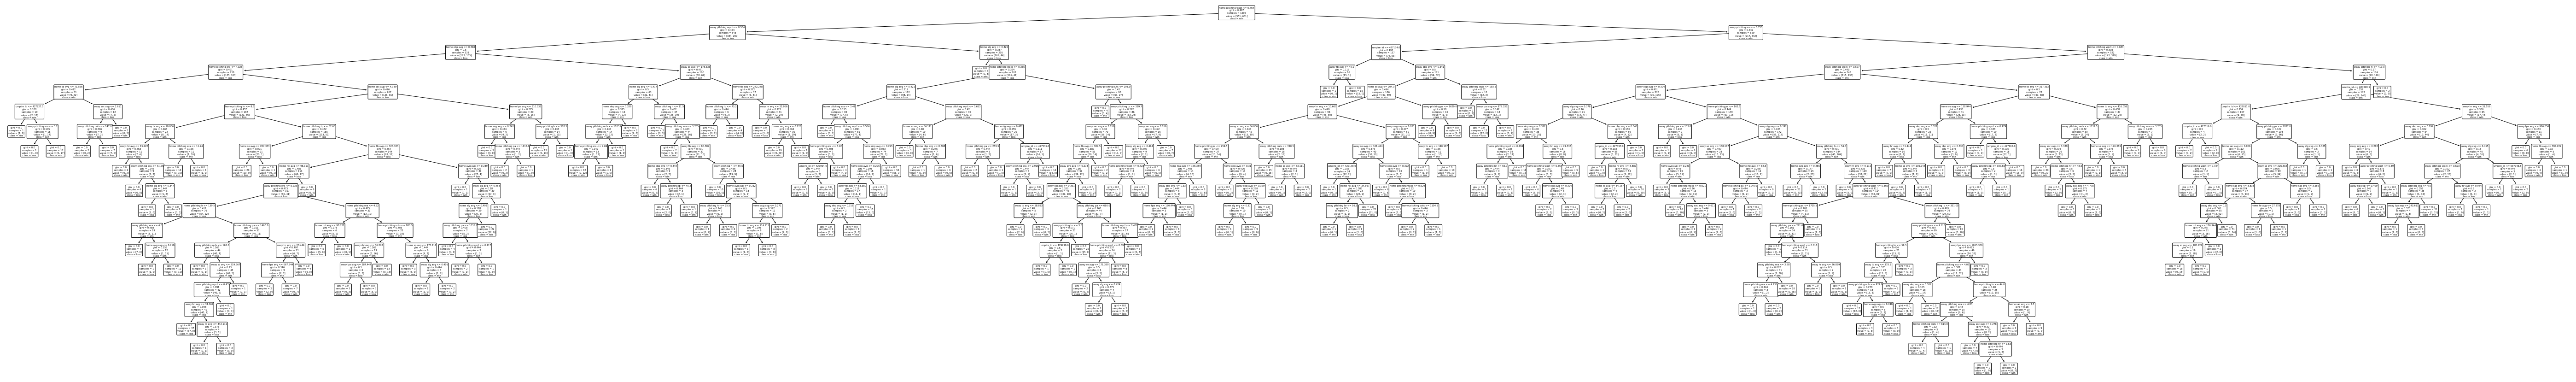

In [33]:
clf_dt = tree.DecisionTreeClassifier()
clf_dt = clf_dt.fit(X, y)
plt.figure(figsize=(100,15))
tree.plot_tree(clf_dt,feature_names=columns,class_names=['loss','win'],rounded=True,fontsize=6);
plt.savefig('dtree_high_dpi',dpi=700)
predictions_dt = clf_dt.predict(X_test)
accuracy = 1-(((y_test != predictions_dt).sum())/len(X_test))
print("Decision Tree Classification")
print("Number of mislabeled points out of a total %d points: %d" % (len(X_test), (y_test != predictions_dt).sum()))
print("Accuracy: %f" % (accuracy))